In [24]:
import pandas as pd
from pandas import read_excel
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from datetime import date, datetime, timedelta, timezone
import copy
from pandas import IndexSlice as idx
pd.set_option('display.max_columns', None)  # 当列太多时不换行
from numpy import exp, nan
import quantstats as qs

# import akshare as ak



import warnings
warnings.filterwarnings('ignore') # 忽略警告
import pandas as pd
from pandas import IndexSlice as idx

import talib as ta



In [25]:
pd.set_option('display.max_columns', None)  # 当列太多时不换行
# df = pd.read_pickle('cb_data.pq') # 导入转债数据
# index = pd.read_pickle('index.pq') # 导入指数数据
df = pd.read_parquet('/Users/yiwei/Desktop/git/cb_data.pq') # 导入转债数据
index = pd.read_parquet('/Users/yiwei/Desktop/git/index.pq') # 导入指数数据

In [26]:
# 基础设置
start_date = '20220801' # 开始日期
end_date = '20250901' # 结束日期
hold_num = 5 # 持有数量
SP = 0.03 # 盘中止盈条件
c_rate =  2 / 1000 # 买卖一次花费的总佣金和滑点（双边）
benchmark = 'index_jsl' # 选择基准，集思录等权:index_jsl, 沪深300:index_300, 中证1000:index_1000, 国证2000:index_2000

In [27]:
# df['max_value'] = df.groupby('code')['close'].transform('max')

# df['max_value_position'] = df['close']/df['max_value']

df['max_value'] = df.groupby('code')['close'].cummax().shift(1)

df['max_value_position'] = df['close']/df['max_value']
# 排除设置
df = df[(df.index.get_level_values('trade_date') >= start_date) & (df.index.get_level_values('trade_date') <= end_date)] # 选择时间范围内数据
df['filter'] = False # 初始化过滤器
df.loc[df.is_call.isin(['已公告强赎', '公告到期赎回','公告实施强赎', '公告提示强赎', '已满足强赎条件']), 'filter'] = True # 排除赎回状态
# df.loc[df.high > 188, 'filter'] = True # 排除收盘价大于150的标的
df.loc[df.close > 155, 'filter'] = True # 排除收盘价大于150的标的
df.loc[df.close < 102, 'filter'] = True # 排除收盘价小于100的标的

df.loc[df.amount < 1000, 'filter'] = True # 排除新债
df.loc[df.volatility < 0.02, 'filter'] = True # 排除新债
df.loc[df.pct_chg > 0.06, 'filter'] = True # 排除新债
df.loc[df.pct_chg < -0.15, 'filter'] = True # 排除新债
df.loc[df.close_stk < 3, 'filter'] = True # 排除新债


df.loc[df.left_years < 0.7, 'filter'] = True # 排除新债
df.loc[df.list_days <= 3, 'filter'] = True # 排除新债

In [28]:
# for col in df.columns:
#     score_col = f'{col}_score'
#     df.loc[df['filter'] == False, score_col] = (
#         df.loc[df['filter'] == False]
#         .groupby('trade_date')[col]
#         .rank(ascending=False)
#     )

for col in df.columns:
    score_col = f'{col}_score'
    df[score_col] = (
        df.loc[df['filter'] == False]
        .groupby('trade_date')[col]
        .rank(ascending=False)
    )


df_with_score = df[df['filter'] == False].copy()

In [29]:
df = df_with_score.copy()

df['score'] = df['bond_prem_score'] * -10 + df['ytm_score'] * 10


# df['score'] = df['bond_prem_score'] * -10 + df['ytm_score'] * 10 + df['theory_bias_score'] * -10 + df['cap_mv_rate_score'] * -10 + df['turnover_5_score'] * 15 + df['remain_cap_score'] * -5 + df['vol_stk_score'] * 1 + df['pct_chg_5_score'] * 1


df['rank'] = df.groupby('trade_date')['score'].rank('first', ascending=True) # 按总分从高到低计算排名

In [30]:
code_group = df.groupby('code')
# (2)次日止盈条件
df['aft_open'] = code_group.open.shift(-1) # 计算次日开盘价
df['aft_close'] = code_group.close.shift(-1) # 计算次日收盘价
df['aft_high'] = code_group.high.shift(-1) # 计算次日最高价
df['time_return']= code_group.pct_chg.shift(-1) # 先计算不止盈情况的收益率
df['SFZY']='未满足止盈' #先记录默认情况
pd.set_option('display.max_columns', None)  # 当列太多时不换行

df.loc[df['aft_high'] >= df['close'] * (1+SP),'time_return'] = SP # 满足止盈条件止盈
df.loc[df['aft_open'] >= df['close'] * (1+SP),'time_return'] = \
(df['aft_open']-df['close'])/df['close'] # 开盘满足止盈条件则按开盘价计算涨幅
df.loc[df['aft_high'] >= df['close'] * (1+SP),'SFZY'] = '满足止盈'

# 计算每日信号 采样信号 持仓状态
df.loc[(df['rank'] <= hold_num), 'signal'] = 1 # 标记信号
df.dropna(subset=['signal'], inplace=True) # 删除没有标记的行
df.sort_values(by='trade_date', inplace=True) # 按日期排序

res = pd.DataFrame()
res['time_return'] = df.groupby('trade_date')['time_return'].mean() # 按等权计算组合回报
pd.set_option('display.max_rows',None)
# 计算手续费
pos_df = df['signal'].unstack('code')
pos_df.fillna(0, inplace=True)
res['cost'] = pos_df.diff().abs().sum(axis=1) * c_rate / (pos_df.shift().sum(axis=1) + pos_df.sum(axis=1))
res.iloc[0, 1] = 0.5 * c_rate# 修正首行手续费
res['time_return'] = (res['time_return'] + 1) * (1 - res['cost']) - 1# 扣除手续费及佣金后的回报

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2022-08-02   2022-08-02
End Period                 2025-03-13   2025-03-13
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          1.52%        167.34%
CAGR﹪                     0.4%         29.66%

Sharpe                     0.11         4.54
Prob. Sharpe Ratio         56.89%       100.0%
Smart Sharpe               0.09         3.83
Sortino                    0.15         10.92
Smart Sortino              0.13         9.22
Sortino/√2                 0.11         7.72
Smart Sortino/√2           0.09         6.52
Omega                      2.58         2.58

Max Drawdown               -20.8%       -2.78%
Longest DD Days            918          89
Volatility (ann.)          11.8%        8.73%
R^2                        0.03         0.03
Information Ratio          0.18         0.18
Calmar              

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-08-15,2022-09-28,2022-11-11,89,-2.782194,-2.703390
2,2024-08-01,2024-08-21,2024-08-26,26,-2.747349,-2.323768
3,2024-05-20,2024-06-05,2024-06-07,19,-2.735091,-1.921525
4,2023-06-02,2023-06-27,2023-07-10,39,-2.449175,-2.025318
5,2024-01-03,2024-02-06,2024-02-07,36,-2.267235,-1.930329


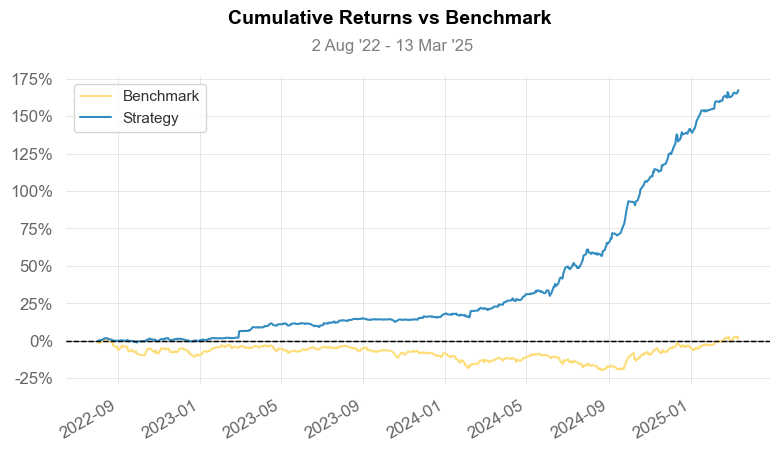

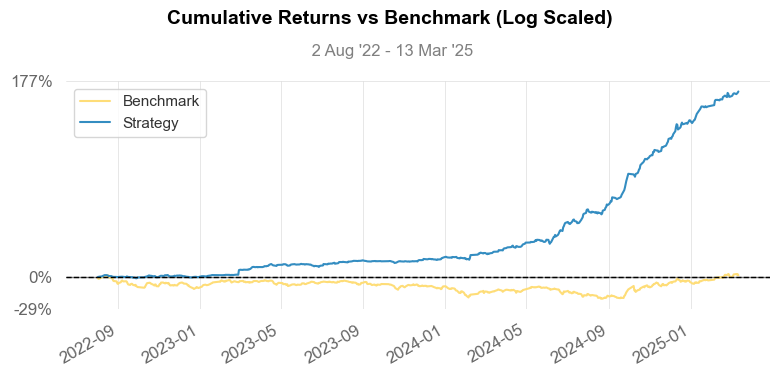

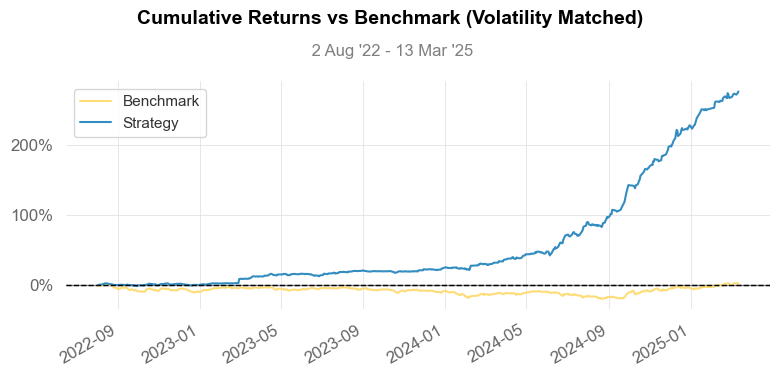

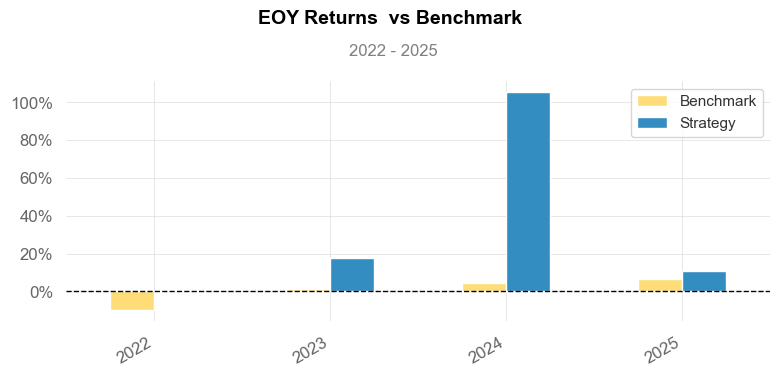

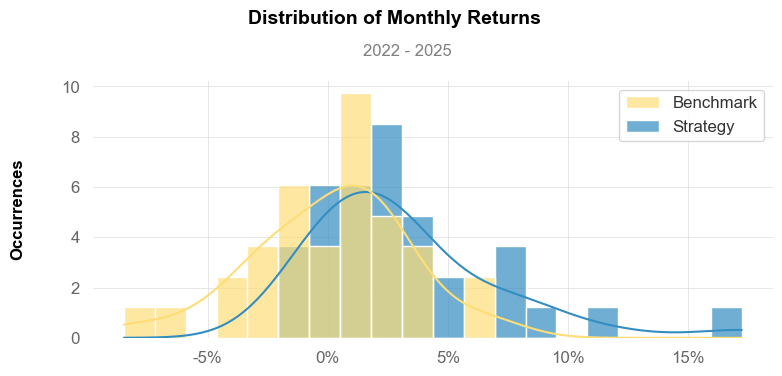

UnsupportedFunctionCall: numpy operations are not valid with resample. Use .resample(...).sum() instead

In [35]:
# qs.reports.full(res.time_return, benchmark=index[benchmark], periods_per_year=12)
qs.reports.full(res.time_return, benchmark=index[benchmark])

In [32]:
# 查看某个交易日选出的标的
df.loc[idx[:,'2025-03-13'],:].sort_values(by='rank') # 查看某日

,,name,pre_close,open,high,low,close,limit,close_ma_5,bias_5,pct_chg,adj_factor,vol,vol_5,amount,amount_5,volatility,code_stk,name_stk,pre_close_stk,open_stk,high_stk,low_stk,close_stk,pct_chg_stk,adj_factor_stk,vol_stk,amount_stk,pe_ttm,pb,ps_ttm,dv_ratio,total_share,float_share,total_mv,circ_mv,debt_to_assets,volatility_stk,is_call,conv_price,conv_value,conv_prem,dblow,issue_size,remain_size,remain_cap,turnover,turnover_5,cap_mv_rate,list_date,list_days,conv_start_date,left_conv_start_days,conv_end_date,left_years,ytm,pure_value,bond_prem,option_value,theory_value,theory_bias,rating,yy_rating,orgform,area,industry_1,industry_2,industry_3,maturity_put_price,maturity,popularity_ranking,pct_chg_5,pct_chg_5_stk,alpha_pct_chg_5,theory_conv_prem,mod_conv_prem,open_pct_chg,high_pct_chg,low_pct_chg,max_value,max_value_position,filter,name_score,pre_close_score,open_score,high_score,low_score,close_score,limit_score,close_ma_5_score,bias_5_score,pct_chg_score,adj_factor_score,vol_score,vol_5_score,amount_score,amount_5_score,volatility_score,code_stk_score,name_stk_score,pre_close_stk_score,open_stk_score,high_stk_score,low_stk_score,close_stk_score,pct_chg_stk_score,adj_factor_stk_score,vol_stk_score,amount_stk_score,pe_ttm_score,pb_score,ps_ttm_score,dv_ratio_score,total_share_score,float_share_score,total_mv_score,circ_mv_score,debt_to_assets_score,volatility_stk_score,is_call_score,conv_price_score,conv_value_score,conv_prem_score,dblow_score,issue_size_score,remain_size_score,remain_cap_score,turnover_score,turnover_5_score,cap_mv_rate_score,list_date_score,list_days_score,conv_start_date_score,left_conv_start_days_score,conv_end_date_score,left_years_score,ytm_score,pure_value_score,bond_prem_score,option_value_score,theory_value_score,theory_bias_score,rating_score,yy_rating_score,orgform_score,area_score,industry_1_score,industry_2_score,industry_3_score,maturity_put_price_score,maturity_score,popularity_ranking_score,pct_chg_5_score,pct_chg_5_stk_score,alpha_pct_chg_5_score,theory_conv_prem_score,mod_conv_prem_score,open_pct_chg_score,high_pct_chg_score,low_pct_chg_score,max_value_score,max_value_position_score,filter_score,score,rank,aft_open,aft_close,aft_high,time_return,SFZY,signal
code,trade_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
127061.SZ,2025-03-13,美锦转债,103.476,103.400,109.998,103.376,109.007,0,103.7292,0.050881,0.053452,1.097603,1050709.3,2030060.7,113751.896093,214279.054125,0.220825,000723.SZ,美锦能源,4.60,4.60,5.06,4.60,5.06,0.100000,0.440075,2349132.11,1159219.352,NaN,1.5636,1.1022,0.000000,443139.6033,439619.8913,224.228639,222.447665,0.630037,0.392389,None,5.26,96.197719,0.133156,122.322577,35.9000,27.893516,30.405885,0.374111,0.722613,0.135602,2022-05-30,1019,2022-10-26,-869,2028-04-19,3.106849,0.040310,111.258807,-0.020239,26.837467,138.096275,-0.266857,AA-,7-,大型民企,山西,化石能源,煤炭,焦炭,118.0,6.0,7,0.109644,0.204762,-0.095118,0.249689,-0.116533,-0.000734,0.063029,-0.000966,120.500,0.904622,False,78.0,345.0,345.0,330.0,345.0,332.0,173.0,345.0,1.0,1.0,330.0,3.0,5.0,3.0,6.0,153.0,335.0,76.0,333.0,333.0,327.0,333.0,326.0,2.0,322.0,1.0,11.0,NaN,250.0,255.0,293.0,24.0,23.0,52.0,51.0,85.0,247.0,NaN,328.0,174.0,264.0,345.0,29.0,46.0,49.0,20.0,53.0,173.0,186.0,160.0,191.5,191.5,189.5,189.5,3.0,20.0,345.0,194.0,143.0,336.0,144.0,156.0,154.0,261.5,262.5,165.5,142.0,13.5,170.5,344.0,1.0,4.0,338.0,172.0,335.0,241.0,1.0,6.0,336.0,111.0,173.0,-3420.0,1.0,108.000,108.830,110.378,-0.001624,未满足止盈,1.0
123049.SZ,2025-03-13,维尔转债,109.600,109.372,110.000,109.131,109.700,0,108.4736,0.011306,0.000912,1.142895,16473.0,75591.6,1807.317860,8213.574122,0.233754,300190.SZ,维尔利,3.29,3.28,3.32,3.24,3.32,0.009119,0.494791,100124.96,32862.192,NaN,0.7361,1.2500,0.002902,78159.7732,77617.3629,25.949045,25.768964,0.569918,0.444660,None,4.63,71.706263,0.529852,162.685241,9.1724,9.169360,10.058788,0.017968,0.082282,0.387636,20